In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk

# NLTK 다운로드
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/한국전자통신_en (1).csv")
docs = df[['독립항_en', 'text_en', '발명의 명칭']]
print(docs.shape)
print(docs.head(3))

def preprocessing(text):
    if isinstance(text, float):
        text = str(text)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z]", " ", text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    stop_words.update(['claim', 'non'])
    tokens = [item for item in tokens if item not in stop_words]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return ' '.join(lemmatized_tokens)

# Apply preprocessing
docs['독립항_en'] = docs['독립항_en'].apply(preprocessing)
docs['text_en'] = docs['text_en'].apply(preprocessing)
docs['발명의 명칭'] = docs['발명의 명칭'].apply(preprocessing)

# Combine the text columns into one
combined_docs = docs['독립항_en'] + " " + docs['text_en'] + " " + docs['발명의 명칭']
docs['all'] = combined_docs

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X = vectorizer.fit_transform(docs['all'])

# 문서-용어 행렬 생성
vect = CountVectorizer()
document_term_matrix = vect.fit_transform(docs['all'])
column_list = vect.get_feature_names_out()

# 단어 쌍 빈도 계산
tf = pd.DataFrame(document_term_matrix.toarray(), columns=column_list)
count_dict = {}

for doc_number in tqdm(range(len(docs)), desc='단어쌍 만들기 진행중'):
    tmp = tf.loc[doc_number]
    for i, word1 in enumerate(column_list):
        if tmp[word1]:
            for j in range(i + 1, len(column_list)):
                if tmp[column_list[j]]:
                    count_dict[(column_list[i], column_list[j])] = count_dict.get((column_list[i], column_list[j]), 0) + max(tmp[word1], tmp[column_list[j]])

# 결과 데이터프레임 생성
count_list = [[words[0], words[1], count_dict[words]] for words in count_dict]
df_result = pd.DataFrame(count_list, columns=["word1", "word2", "freq"])
df_result = df_result.sort_values(by=['freq'], ascending=False).reset_index(drop=True)
df_result =  df_result[df_result['freq'] >= 20]

# 네트워크 그래프 생성
G = nx.Graph()

for _, row in df_result.iterrows():
    G.add_edge(row['word1'], row['word2'], weight=row['freq'])

plt.figure(figsize=(50, 50))

node_size = [G.degree(node) * 100 for node in G.nodes()]
edge_width = [d['weight'] / 10 for (u, v, d) in G.edges(data=True)]
pos = nx.spring_layout(G, k=0.1)
nx.draw_networkx(G, pos, node_size=node_size, width=edge_width, with_labels=True, font_size=12)
plt.title('Word Pair Network')
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#gexf 형식으로 저장하기
nx.write_gexf(G,r"/content/drive/MyDrive/net_text_810.gexf")

In [ ]:
#!pip install node2vec

In [ ]:
!pip install gensim
!pip show gensim
!pip install gensim[embedding]
!pip show gensim.models.embeddings

Name: gensim
Version: 4.3.2
Summary: Python framework for fast Vector Space Modelling
Home-page: https://radimrehurek.com/gensim/
Author: Radim Rehurek
Author-email: me@radimrehurek.com
License: LGPL-2.1-only
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, scipy, smart-open
Required-by: node2vec


In [ ]:
#Node2Vec
from node2vec import Node2Vec

node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
model.wv.most_similar('neuromorphic')

Computing transition probabilities:   0%|          | 0/133 [00:00<?, ?it/s]

[('load', 0.938136100769043),
 ('mount', 0.9282429814338684),
 ('therefor', 0.9257615804672241),
 ('form', 0.9208554625511169),
 ('components', 0.9191513061523438),
 ('identify', 0.9152683019638062),
 ('piece', 0.9141667485237122),
 ('manage', 0.9120374321937561),
 ('element', 0.9075862169265747),
 ('plurality', 0.9050388336181641)]

In [ ]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/133 [00:00<?, ?it/s]

In [ ]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [ ]:
model.wv.most_similar('hardware')

[('therefor', 0.9261378645896912),
 ('manage', 0.9259803295135498),
 ('mount', 0.9183599948883057),
 ('identify', 0.9160057902336121),
 ('plurality', 0.9157136082649231),
 ('load', 0.9119815826416016),
 ('part', 0.9112327694892883),
 ('compute', 0.9075483679771423),
 ('piece', 0.9049469828605652),
 ('components', 0.9041542410850525)]

In [ ]:
#HadamardEmbedder
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)
edges_kv.most_similar(str(('ai','neuromorphic')))

[("('ai', 'piece')", 0.9489324688911438),
 ("('ai', 'components')", 0.9449970722198486),
 ("('ai', 'element')", 0.9331189393997192),
 ("('ai', 'elements')", 0.9330400228500366),
 ("('ai', 'compute')", 0.9329027533531189),
 ("('ai', 'form')", 0.9310858845710754),
 ("('ai', 'part')", 0.9186350107192993),
 ("('ai', 'load')", 0.9162874817848206),
 ("('ai', 'identify')", 0.9158295392990112),
 ("('ai', 'plurality')", 0.9085084199905396)]

In [ ]:
edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

In [ ]:
edges_embs[('semiconductor','neuromorphic')]

array([ 6.9525871e-05, -8.3925907e-04,  2.2998925e-02,  5.1637655e-03,
       -7.5158565e-03, -7.8306310e-03, -1.2975892e-03,  7.3386603e-03,
        8.5718468e-02, -1.1102027e-03,  9.8801991e-03,  4.8605362e-03,
       -2.3664644e-02, -2.2125605e-02, -2.6370037e-02, -9.5424140e-03,
       -3.4035740e-03, -1.4007752e-02,  6.7150667e-03,  1.4940518e-02,
       -2.1744963e-02, -6.6998256e-03, -1.9790070e-02,  9.9414086e-05,
        4.7103400e-04, -3.0701252e-04, -6.4561106e-02,  5.9217617e-02,
       -1.7983980e-02,  3.1072597e-04, -1.6637457e-03,  2.4077203e-03,
        3.8740255e-02, -5.1382881e-02,  1.6313104e-02,  1.6314046e-02,
        1.8131867e-02,  5.4860408e-03, -2.7155485e-03,  6.6955877e-03,
        6.6631343e-03,  4.0009737e-02,  3.6466034e-04, -2.8471625e-03,
        3.2818560e-02,  2.1337811e-02, -5.2583277e-02,  2.9522290e-02,
       -7.1340231e-03, -3.4754348e-04,  1.8265698e-02,  4.1080691e-02,
        7.3670479e-03,  8.4208623e-02, -1.3457682e-03, -2.1285589e-03,
      

In [ ]:
edges_kv = edges_embs.as_keyed_vectors()

Generating edge features: 100%|██████████| 8911/8911.0 [00:00<00:00, 60433.37it/s]


In [ ]:
edges_kv.most_similar(str(('ai','neuromorphic')))

[("('ai', 'manage')", 0.9423578977584839),
 ("('ai', 'mount')", 0.9353172183036804),
 ("('ai', 'compute')", 0.9182241559028625),
 ("('ai', 'load')", 0.9120653867721558),
 ("('ai', 'plurality')", 0.9111666679382324),
 ("('ai', 'therefor')", 0.9081085920333862),
 ("('ai', 'identify')", 0.9073489308357239),
 ("('ai', 'components')", 0.902683675289154),
 ("('ai', 'part')", 0.9019951820373535),
 ("('ai', 'form')", 0.8985830545425415)]

In [ ]:
edges_kv.save_word2vec_format('EDGES_EMBEDDING_aise')

In [ ]:
#워드클라우드 분석에 필요한 모듈 및 패키지 설치
!pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

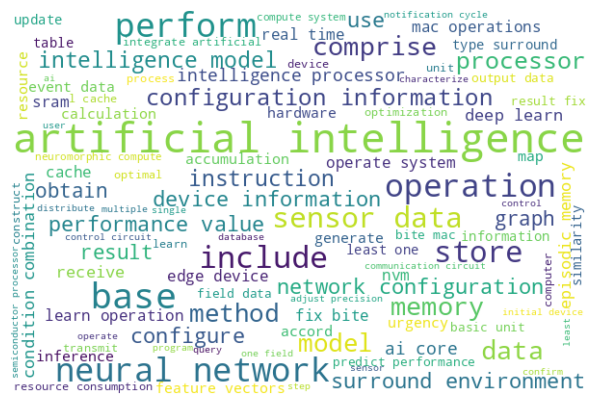

In [ ]:
#불용어 적용 및 추가
stop_words = stopwords.words('english')
stop_words.append('claim')
print(stop_words)
print(len(stop_words))

#텍스츠 전처리
docs = docs.astype(str).str.lower()
docs = docs.apply(lambda x: re.sub("[^a-zA-Z]", " ", x))
docs = docs.apply(word_tokenize)
docs = docs.apply(lambda x: [item for item in x if item not in stop_words])
docs = docs.apply(lambda x: ' '.join(x))

all_text = ' '.join(docs)

#워크클라우드 시각화
wordcloud = WordCloud(width=600, height=400,max_words=100,background_color="white",max_font_size=100).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
icon = Image.open('./image.png')    # 마스크가 될 이미지 불러오기
plt.imshow(icon)

mask = Image.new("RGB", icon.size, (255,255,255))
mask.paste(icon,icon)
mask = np.array(mask)